In [1]:
library(ggplot2)
library(reshape2)
library(sqldf)
library(fields)
library(gridExtra)
library(ggtern)
library(clue)
library(geometry)
library(gtable)
library(goseq)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
--
Consider donating at: http://ggtern.com
Even small amounts (say $10-50) are very much appreciated!
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:gridExtra’:

    arrangeGrob, grid.arrange

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot_gtable, ggplot

In [2]:
folder<-"./TablesForExploration"

loadGeneInformation<-function(dir="../TablesForExploration"){
    path<-paste0(dir,"/CanonicalTranscript.rds")
    canonicalTranscripts<-readRDS(path)
    canonicalTranscripts$intron_length<- canonicalTranscripts$mrna_length -  canonicalTranscripts$exon_length
    canonicalTranscripts$chr_group <- substr(canonicalTranscripts$Chr,4,4)
    canonicalTranscripts$genome    <- substr(canonicalTranscripts$Chr,5,5)
    
    path<-paste0(dir, "/MeanTpms.rds")
    meanTpms <- readRDS(path)
    
    path<-paste0(dir,"/TriadMovement.rds")
    triadMovement<-readRDS(path)
    
    path<-paste0(dir,"/Triads.rds")
    triads<-readRDS(path)
    
    path<-paste0(dir,"/universe_table.csv")
    gene_universe<-read.csv(path)
    
    path<-paste0(dir, "/OntologiesForGenes.rds")
    ontologies<-readRDS(path)
    
    path<-paste0(dir, "/id_names_merged.txt")
    id_names <- read.csv(path, header=F, sep = "\t")
    
    path<-paste0(dir, "/WGCNA_table.csv")
    WGCNA <-  read.csv(path)
    
    list(canonicalTranscripts=canonicalTranscripts, 
         meanTpms=meanTpms,
         triads=triads, 
         triadMovement=triadMovement,
         gene_universe=gene_universe, 
         ontologies=ontologies,
         id_names=id_names,
         WGCNA=WGCNA
        )
}
geneInformation<-loadGeneInformation(dir=folder)

# Variation in homoeolog expression bias across tissues (Stable/Dynamic triads).

To define the variation in homoeolog expression bias of each triad across the intermediate tissues we calculated the Euclidean distance between the triad’s global position (combined analysis) and each
individual tissue in which the triad was considered expressed. We included only triads which were considered expressed in at least six tissues based on the combined analysis criteria outlined above. The average of these distances was defined as the “triad mean distance”. We ranked triads by their triad mean distance and the percentile was calculated by:

$$percentile_{i} = truncate\left(\frac{rank(cmd_{i})}{length(CMD)}\right)$$

where $CMD$ is the vector containing all the ‘triad mean distance'. The first and last deciles where classified as stable 10% and dynamic 10% triads, respectively. A similar approach was used to define the correspond 5% and 25% extremes of the distribution. This analysis was conducted independently for the Chinese Spring no stress samples, the Azhurnaya developmental time course, and for each of the four tissue-specific networks. A visual representation is provided in Fig. S18.
   
A detailed example of one triad across tissues is presented in Table S36 to illustrate how a triad which is expressed across six or more tissues based on the combined analysis, can include individual homoeologous genes which are expressed across less than six tissues. Fig. 3E in the main text illustrates this as we plotted the graph based on genes, and not triads. These criteria were used to ensure that we did not discard triads in which only a single homoeolog was expressed (dominant).

In [3]:
unique(geneInformation$triadMovement$dataset)

[1] HC_Development            HC_850_samples           
 [3] HC_CS_no_stress           HC_CS_NB_inc_stress      
 [5] HC_abiotic                HC_disease               
 [7] HC_grain                  HC_leaf                  
 [9] HC_root                   HC_spike                 
[11] HC_abiotic_merged_control HC_disease_merged_control
[13] HC_stress_control         HC_abiotic_stress_control
[15] HC_disease_stress_control HC_abiotic_stress        
[17] HC_disease_stress         HC_stress                
18 Levels: HC_Development HC_850_samples ... HC_stress

In [4]:
getBottomAndTopPercent<-function(geneInformation, 
                                 dataset="HC_CS_no_stress", 
                                min_factor_count=5){
    
    triadMovement<-geneInformation$triadMovement
    triads<-geneInformation$triads
    local_tm <- triadMovement[triadMovement$dataset == dataset & 
                              triadMovement$factor_count > min_factor_count ,
                             c("group_id","central_mean_distance")]

    local_tm$rank <- rank(local_tm$central_mean_distance) / nrow(local_tm)
    
    low_10 <- local_tm[local_tm$rank < 0.1, ] 
    low_25 <- local_tm[local_tm$rank < 0.25, ]
    low_50 <- local_tm[local_tm$rank < 0.50, ]
    top_10 <- local_tm[local_tm$rank > 0.9, ]
    top_50 <- local_tm[local_tm$rank > 0.50, ]
    top_25 <- local_tm[local_tm$rank > 0.75, ]
    
    middle20pc <- local_tm[local_tm$rank < 0.60 & local_tm$rank > 0.40, ]
    print(nrow(local_tm))
    
    low_10$category<-"low_10pc"
    low_25$category<-"low_25pc"
    top_25$category<-"top_25pc"
    top_10$category<-"top_10pc"
    top_50$category<-"top_50pc"
    low_50$category<-"low_50pc"
    middle20pc$category<-"middle_40to60pc"
    
    groups<-rbind(low_10,low_25,top_10, top_25, top_50, low_50, middle20pc)
    genes<-sqldf("SELECT DISTINCT gene, category from groups JOIN triads ON 
triads.group_id = groups.group_id")
    genes
}

colnames(geneInformation$triadMovement)
head(geneInformation$triadMovement$category)
for(dataset in c("HC_CS_no_stress", "HC_Development", "HC_850_samples" )){
    dir_path <- paste0("./gene_set_files/movement/",dataset,"/")
    if(dir.exists(dir_path)){
        print(dir_path)
        print("Dir exists! ")
        next
    }
    dir.create(dir_path, recursive=T)
    gene_cats <- getBottomAndTopPercent(geneInformation, dataset=dataset)
    for(cat in unique(gene_cats$category)){
        name<-paste0(dataset,"_movement_",cat)
        print(name)
        genes_to_plot<-gene_cats[gene_cats$category == cat, "gene"]
    
        write.csv(genes_to_plot, file=paste0(dir_path,name,".txt"), 
                  row.names=F)
    }
}


[1] "group_id"               "factor_count"           "central_total_distance"
 [4] "central_mean_distance"  "central_max_distance"   "central_sd_distance"   
 [7] "central_max_over_mean"  "factor_total_distance"  "factor_mean_distance"  
[10] "factor_max_distance"    "factor_sd_distance"     "factor_max_over_mean"  
[13] "category"               "sum_mean_tpm"           "total_categories"      
[16] "categories"             "Central"                "A.dominant"            
[19] "A.suppressed"           "B.dominant"             "B.suppressed"          
[22] "D.dominant"             "D.suppressed"           "dataset"

[1] "B.suppressed" "Central"      "Central"      "B.suppressed" "A.suppressed"
[6] "Central"

[1] "./gene_set_files/movement/HC_CS_no_stress/"
[1] "Dir exists! "
[1] "./gene_set_files/movement/HC_Development/"
[1] "Dir exists! "
[1] "./gene_set_files/movement/HC_850_samples/"
[1] "Dir exists! "


[1] 14258


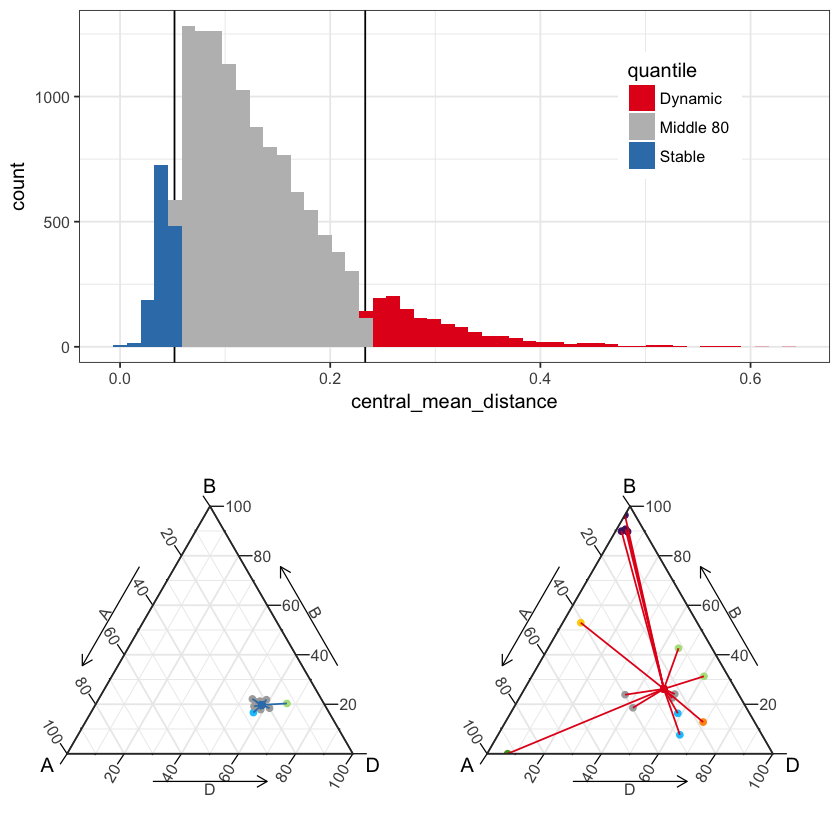

In [5]:
movment.colors <- c("Dynamic"="#e41a1c", "Middle 80"="#bdbdbd", "Stable"="#377eb8") 
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}
group.colors<-c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
             Central="#AAAAAA",Balanced="#AAAAAA", 
             A.suppressed = "#b2E08a", B.suppressed = "#0eC7ff", D.suppressed ="#ffCF0e")
chr.colors<-c(A = "#579D1C", B = "#4B1F6F", D ="#FF950E")
                      
plot_movement_of_triad<-function(triads_df, group_id=1788, 
                                  group.colors = c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
                        Central="#AAAAAA", 
                        A.suppressed = "#7FD127", B.suppressed = "#7D31AF", D.suppressed ="#FFAD42" ), 
                                 movment.colors = c("Dynamic"="#e41a1c", "Middle 80"="#bdbdbd", "Stable"="#377eb8"), 
                                mean.color="#000000"
                                ){
     test_triad2 <-triads_df  [triads_df$group_id==group_id,]
     mean        <-test_triad2[test_triad2$factor=="all_mean_filter", ]
     test_triad2 <-test_triad2[test_triad2$factor!="all_mean_filter", ]
     test_triad3 <-test_triad2
     group.colors["mean"]<-mean.color
     test_triad3$A<-mean$A
     test_triad3$B<-mean$B
     test_triad3$D<-mean$D
     test_triad3$description<-"mean"
     
     test_triad4<-rbind(test_triad2,test_triad3)
     #print(head(test_triad2))
     
     p <- ggtern(test_triad4,aes(A,B,D, color=description))
     p <- p + geom_point()  
     p <- p + geom_line(aes(group=factor),color=mean.color)
     p <- p + scale_color_manual(values=group.colors)
     p <- p + theme_bw()   
     p <- p + theme(legend.position = "none") + theme_arrownormal()
     p <- p + theme(tern.axis.ticks.length.major = unit(0.6, "cm"))
     p
}



plotHistogram<-function(table, column="size_cds", 
                        probs = c( 0.1, 0.25, 0.5, 0.75, 0.9, 0.95), 
                        movment.colors = c("Dynamic"="#e41a1c", "Middle 80"="#bdbdbd", "Stable"="#377eb8") ){
    table<-table[table[,column]>0,]
    quantiles <- data.frame(quantile(table[,column],
                                     prob=probs,
                                     na.rm=TRUE, 
                                     include.lowest=TRUE), 
                            stringsAsFactors=FALSE)
    quantiles$quant<-rownames(quantiles)
    #print(head(quantiles))
    colnames(quantiles)<-c("value", "quant")
    values<-quantiles$values
    local_mean<-mean(table[,column])
    local_sd<-sd(table[,column])
    local_max <-  max(table[,column])
    p <- ggplot(table, aes_string(column))
   
     table <- within(table,
         quantile <- as.integer(
             cut(table[,column],
                 unique(quantile(table[,column], 
                    prob=probs,
                    na.rm=TRUE, 
                    include.lowest=TRUE))
                 )
             ))

     
    iq <- quantiles$value[4] - quantiles$value[2]

     xmax <- quantiles$value[3] + (iq * 2)
     xmin <- quantiles$value[3] - (iq * 2)
     
    table$quantile<-ifelse(is.na(table$quantile),ifelse(table[,column] < 0.2, "Stable","Dynamic"), "Middle 80")
    table$quantile<-as.factor(table$quantile)
     
     p <- ggplot(table, aes_string(column, fill="quantile"))
     p <- p + geom_vline(data=quantiles,aes(xintercept=quantiles$value) )
     for(i in seq(1,nrow(quantiles))){
        x_pos<-quantiles$value[i]
    }
    p <- p  + xlim(xmin, xmax) #+
    p <- p +  scale_fill_manual(values=movment.colors)
    p <- p + geom_histogram(bins=50, position = "identity") + theme_bw() 
    p <- p + theme(plot.title = element_text(size=6))
    #p <- p + theme(legend.direction = "horizontal")
    p <- p + theme(legend.position = c(0.8, 0.7))
    p
} 


plot_panel_3B<-function(geneInformation, 
                        dataset="HC_CS_no_stress",
                        min_tissues = 5,
                        movment.colors = c("Dynamic"="#e41a1c", "Middle 80"="#bdbdbd", "Stable"="#377eb8") ){
    
   triads<-geneInformation$triads
   triads <- triads[triads$dataset==dataset, 
                    c("group_id", "factor", "description", "triad_sum", "chr_group", "normalised_triad")]
   triads_df<-dcast(triads, group_id+factor+description+triad_sum~chr_group, value.var="normalised_triad")


    gs<-list()
    movements_for_dist<-geneInformation$triadMovement[
        geneInformation$triadMovement$dataset==dataset & 
        geneInformation$triadMovement$factor_count > min_tissues,]
    print(nrow(movements_for_dist))
    p<-plotHistogram(movements_for_dist, "central_mean_distance", probs=c(0.1,0.9), movment.colors=movment.colors)
    gs[[length(gs)+1]] <- p
    
    gs[[length(gs)+1]] <- plot_movement_of_triad(triads_df, 
                                                 group_id=18634, 
                                                 group.colors=group.colors, 
                                                 mean.color = movment.colors["Stable"])
    
    gs[[length(gs)+1]] <- plot_movement_of_triad(triads_df, 
                                                 group_id=14338,
                                                 group.colors=group.colors,
                                                mean.color = movment.colors["Dynamic"])
    
    lay <- rbind(c( 1, 1),
                 c( 2, 3)
                 )

    g2 <- arrangeGrob(grobs = gs, layout_matrix = lay, top = title)
    g2
}




g<-plot_panel_3B(geneInformation)
grid.draw(g)

In [6]:
get_unique_and_ubiquitous<-function(geneInformation){
    genes_per_factor<-geneInformation$meanTpms[]
    genes_per_factor<-genes_per_factor[genes_per_factor$factor == "all_mean_filter",]
    unique<-genes_per_factor[genes_per_factor$samples==1,c("gene", "subset")]
    
    max_values <- aggregate(samples ~ subset, data = genes_per_factor, max)
    ubiquitous <- sqldf("SELECT gene, max_values.subset FROM genes_per_factor JOIN 
max_values ON genes_per_factor.subset = max_values.subset AND
genes_per_factor.samples = max_values.samples")
    

    unique$category <- "unique"
    ubiquitous$category <- "ubiquitous"
    genes<-rbind(unique, ubiquitous)
    genes<-genes[!endsWith(genes$gene,"LC"),]
    genes
}
ubiquitous_unique<-get_unique_and_ubiquitous(geneInformation)
ubiquitous_unique

,gene,subset,category
4313385,TraesCS1A01G002900,stress,unique
4313407,TraesCS1A01G004000,stress,unique
4313415,TraesCS1A01G004400,stress,unique
4313429,TraesCS1A01G005100,stress,unique
4313435,TraesCS1A01G005400,stress,unique
4313451,TraesCS1A01G006200,stress,unique
4313457,TraesCS1A01G006500,stress,unique
4313463,TraesCS1A01G006800,stress,unique
4313467,TraesCS1A01G007000,stress,unique
4313469,TraesCS1A01G007100,stress,unique


In [7]:
for(dataset in unique(ubiquitous_unique$subset)){
    dir_path <- paste0("gene_set_files/UniqueUbiquitous/",dataset,"/")
    dir.create(dir_path, recursive=T)
    gene_cats <- ubiquitous_unique[ubiquitous_unique$subset == dataset,]
    for(cat in unique(gene_cats$category)){
        name<-paste0(dataset,"_",cat)
        print(name)
        genes_to_plot<-gene_cats[gene_cats$category == cat, "gene"]
    
        write.csv(genes_to_plot, file=paste0(dir_path,name,".txt"), 
                  row.names=F)
    }
    
}


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/stress' already exists”

[1] "stress_unique"
[1] "stress_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/disease_stress' already exists”

[1] "disease_stress_unique"
[1] "disease_stress_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/abiotic_stress' already exists”

[1] "abiotic_stress_unique"
[1] "abiotic_stress_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/disease_stress_control' already exists”

[1] "disease_stress_control_unique"
[1] "disease_stress_control_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/abiotic_stress_control' already exists”

[1] "abiotic_stress_control_unique"
[1] "abiotic_stress_control_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/stress_control' already exists”

[1] "stress_control_unique"
[1] "stress_control_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/disease_merged_control' already exists”

[1] "disease_merged_control_unique"
[1] "disease_merged_control_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/abiotic_merged_control' already exists”

[1] "abiotic_merged_control_unique"
[1] "abiotic_merged_control_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/spike' already exists”

[1] "spike_unique"
[1] "spike_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/root' already exists”

[1] "root_unique"
[1] "root_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/leaf' already exists”

[1] "leaf_unique"
[1] "leaf_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/grain' already exists”

[1] "grain_unique"
[1] "grain_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/disease' already exists”

[1] "disease_unique"
[1] "disease_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/abiotic' already exists”

[1] "abiotic_unique"
[1] "abiotic_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/CS_NB_inc_stress' already exists”

[1] "CS_NB_inc_stress_unique"
[1] "CS_NB_inc_stress_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/CS_no_stress' already exists”

[1] "CS_no_stress_unique"
[1] "CS_no_stress_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/850_samples' already exists”

[1] "850_samples_unique"
[1] "850_samples_ubiquitous"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/UniqueUbiquitous/Development' already exists”

[1] "Development_unique"
[1] "Development_ubiquitous"


In [8]:
getGenesForCaregory<-function(geneInformation, 
                                 dataset="HC_CS_no_stress", 
                                min_factor_count=5){
    
    triadMovement<-geneInformation$triadMovement
    triads<-geneInformation$triads
    local_tm <- triadMovement[triadMovement$dataset == dataset & 
                              triadMovement$factor_count > min_factor_count ,
                             c("group_id","category")]
    
    
    groups<-local_tm
    genes<-sqldf("SELECT DISTINCT gene, category from groups JOIN triads ON 
triads.group_id = groups.group_id")
    genes
}

#colnames(geneInformation$triadMovement)
head(geneInformation$triadMovement$category)
test_categories<-getGenesForCaregory(geneInformation)

[1] "B.suppressed" "Central"      "Central"      "B.suppressed" "A.suppressed"
[6] "Central"

In [ ]:
for(dataset in unique(geneInformation$triadMovement$dataset)){
    dir_path <- paste0("gene_set_files/movement/",dataset,"/")
    dir.create(dir_path, recursive=T)
    gene_cats <- getGenesForCaregory(geneInformation, 
                                     dataset=dataset, 
                                     min_factor_count = 5)
    for(cat in unique(gene_cats$category)){
        name<-paste0(dataset,"_movement_",cat)
        print(name)
        genes_to_plot<-gene_cats[gene_cats$category == cat, "gene"]
    
        write.csv(genes_to_plot, file=paste0(dir_path,name,".txt"), 
                  row.names=F)
    }
    
}



Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_Development' already exists”

[1] "HC_Development_movement_B.suppressed"
[1] "HC_Development_movement_Central"
[1] "HC_Development_movement_A.suppressed"
[1] "HC_Development_movement_B.dominant"
[1] "HC_Development_movement_A.dominant"
[1] "HC_Development_movement_D.suppressed"
[1] "HC_Development_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_850_samples' already exists”

[1] "HC_850_samples_movement_B.suppressed"
[1] "HC_850_samples_movement_Central"
[1] "HC_850_samples_movement_D.suppressed"
[1] "HC_850_samples_movement_A.suppressed"
[1] "HC_850_samples_movement_B.dominant"
[1] "HC_850_samples_movement_A.dominant"
[1] "HC_850_samples_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_CS_no_stress' already exists”

[1] "HC_CS_no_stress_movement_Central"
[1] "HC_CS_no_stress_movement_A.dominant"
[1] "HC_CS_no_stress_movement_A.suppressed"
[1] "HC_CS_no_stress_movement_B.dominant"
[1] "HC_CS_no_stress_movement_D.suppressed"
[1] "HC_CS_no_stress_movement_B.suppressed"
[1] "HC_CS_no_stress_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_CS_NB_inc_stress' already exists”

[1] "HC_CS_NB_inc_stress_movement_Central"
[1] "HC_CS_NB_inc_stress_movement_A.dominant"
[1] "HC_CS_NB_inc_stress_movement_B.dominant"
[1] "HC_CS_NB_inc_stress_movement_A.suppressed"
[1] "HC_CS_NB_inc_stress_movement_D.suppressed"
[1] "HC_CS_NB_inc_stress_movement_B.suppressed"
[1] "HC_CS_NB_inc_stress_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_abiotic' already exists”

[1] "HC_abiotic_movement_Central"
[1] "HC_abiotic_movement_B.dominant"
[1] "HC_abiotic_movement_B.suppressed"
[1] "HC_abiotic_movement_D.dominant"
[1] "HC_abiotic_movement_D.suppressed"
[1] "HC_abiotic_movement_A.suppressed"
[1] "HC_abiotic_movement_A.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_disease' already exists”

[1] "HC_disease_movement_Central"
[1] "HC_disease_movement_B.dominant"
[1] "HC_disease_movement_A.suppressed"
[1] "HC_disease_movement_A.dominant"
[1] "HC_disease_movement_D.suppressed"
[1] "HC_disease_movement_B.suppressed"
[1] "HC_disease_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_grain' already exists”

[1] "HC_grain_movement_Central"
[1] "HC_grain_movement_B.suppressed"
[1] "HC_grain_movement_A.suppressed"
[1] "HC_grain_movement_B.dominant"
[1] "HC_grain_movement_A.dominant"
[1] "HC_grain_movement_D.suppressed"
[1] "HC_grain_movement_D.dominant"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_leaf' already exists”

[1] "HC_leaf_movement_Central"
[1] "HC_leaf_movement_B.suppressed"
[1] "HC_leaf_movement_B.dominant"
[1] "HC_leaf_movement_A.dominant"
[1] "HC_leaf_movement_D.dominant"
[1] "HC_leaf_movement_A.suppressed"
[1] "HC_leaf_movement_D.suppressed"


Warning message in dir.create(dir_path, recursive = T):
“'gene_set_files/movement/HC_root' already exists”